# Using FCN to detect landmark point

In [85]:
# Dealing with the data
import networkx as nx
from process_it import process_it
import os
import argparse
import networkx as nx
import math        
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time

def state_to_numpy(state):
    strlist = state.split()
    val_list = [float(s) for s in strlist]
    return np.array(val_list)

def numpy_to_state(array):
    state = ""
    for i in range(len(array)):
        state += str(array[i])+" "
    return state

def list_all_dir(data_dir):
    task_dirs = os.listdir(data_dir)

    list_dir = []
    for task_dir in task_dirs:
        env_dirs = os.listdir(data_dir+"/"+task_dir)
        for env_dir in env_dirs:
            list_dir.append(data_dir +"/"+ task_dir +"/"+ env_dir)
    return list_dir  

def detection_data(G, directory, grid, with_start_goal=False):
    start = np.loadtxt(directory+"/start_nodes.txt")
    goal = np.loadtxt(directory+"/goal_nodes.txt")
    occ_grid = np.loadtxt(directory+"/occ_grid.txt")
    path_nodes = []
    occ = {} # dict
    ini = {}
    end = {}
    i = 0
    all_data = []
    with open(directory + "/path_nodes.txt", 'r') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip('\n')
            
            s = state_to_numpy(G.nodes[str(int(start[i]))]['state'])
            g = state_to_numpy(G.nodes[str(int(goal[i]))]['state'])
            og = occ_grid[i]
            path_nodes = str(line).split(",")
            # print(path_nodes)
            for path_node in path_nodes:
                if(path_node=='-1'):
                    continue
                
                node_conf = state_to_numpy(G.nodes[path_node]['state'])
                curr_node = np.array([])
                
                og = og.astype(np.int32)
                str_og = numpy_to_state(og)
                if str_og not in occ.keys():
                    occ[str_og] = np.zeros((10*grid, 10*grid))
                if str_og not in ini.keys():
                    ini[str_og] = np.zeros((10*grid, 10*grid))
                if str_og not in end.keys():
                    end[str_og] = np.zeros((10*grid, 10*grid))
                occ[str_og][int(node_conf[0]*10*grid)][int(node_conf[1]*10*grid) + 1] = 1
                ini[str_og][int(s[0]*10*grid)][int(s[1]*10*grid)] = 1
                end[str_og][int(g[0]*10*grid)][int(g[1]*10*grid)] = 1
            i += 1 
    for element in occ:
        tmp_occ = state_to_numpy(element)
        tmp_occ = tmp_occ.astype(np.uint8)
        tmp_occ = tmp_occ.reshape(10, 10)
        tmp_occ = tmp_occ.repeat(grid, axis = 0)
        tmp_occ = tmp_occ.repeat(grid, axis = 1)
        
        data = []
        data.append(tmp_occ)
        data.append(occ[element])
        if with_start_goal == True:
            data.append(ini[element])
            data.append(end[element])
        data = np.array(data)
        all_data.append(data)
    all_data = np.array(all_data)
    return all_data

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.vgg import VGG


class FCN32s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)g
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)




In [87]:
print(torch.__version__)
import torchvision


1.4.0


# FCN Training

In [88]:
import argparse
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()
parser.add_argument("--max_epochs", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=16, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--eps", type=float, default=1e-8, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--grid", type=int, default=16, help="the ratio to expand the environment")
#parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
#parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
#parser.add_argument("--channels", type=int, default=1, help="number of image channels")
#parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

Namespace(b1=0.9, b2=0.999, batch_size=16, eps=1e-08, grid=16, lr=0.0001, max_epochs=1000, n_cpu=8)


In [5]:
# Loading data


# Dataloader
from torch.utils.data import Dataset, DataLoader
class DetectionSet(Dataset):
    def __init__(self, data, with_start_goal=True, gaussian=False):
        if with_start_goal == True:
            
            self.data = torch.FloatTensor(data[:,[0,2,3]])
            self.label = torch.IntTensor(data[:,1])
            print(self.data.shape)
            print(self.label.shape)
        else:
            self.data = torch.FloatTensor(data[:,0])
            self.label = torch.FloatTeensor(data[:, 1])
            
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    
    def __len__(self):
        return len(self.data)

G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset"
data = detection_data(G, data_dir, 16, with_start_goal = True)
ratioTestTrain = 0.8
numtotal = data.shape[0]
train_data = data[0:int(numtotal*ratioTestTrain)]
test_data = data[int(numtotal*ratioTestTrain):numtotal]
train_set = DetectionSet(data = train_data, with_start_goal = True)
train_loader = DataLoader(train_set, batch_size = opt.batch_size, shuffle = True)
#test_set = DetectionSet(data = test_data, with_start_goal = True)
#test_loader = DataLoader(test_set, batch_size = opt.batch_size, shuffle = True)



torch.Size([863, 3, 160, 160])
torch.Size([863, 160, 160])


In [89]:
# VGG = VGGNet(pretrained = False)
# FCN32s = FCN32s(pretrained_net = VGG, n_class = 2)
# FCN16s = FCN16s(pretrained_net = VGG, n_class = 2)
# FCN8s = FCN8s(pretrained_net = VGG, n_class = 2)
# FCNs = FCNs(pretrained_net = VGG, n_class = 2)


VGG = VGGNet(pretrained = False)
net = FCN32s(pretrained_net = VGG, n_class = 1)

resume = None
# resume = ""
if resume == None:
    i = 9
else:
    net.load_state_dict(torch.load(resume))
    
if torch.cuda.is_available():
    net.cuda()
net.train()
optimizer = optim.Adam(net.parameters(), lr=opt.lr, 
                      betas=(opt.b1, opt.b2), eps=opt.eps, weight_decay=0)
schedular = optim.lr_scheduler.MultiStepLR(optimizer, 
                      milestones = [50,200, 500, 1000, 2000], gamma = 0.1)

#criterion = nn.BCELoss()
criterion = nn.MSELoss()

#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter("/home/zhizuo/lego/tensorboard")


# Training

In [67]:
opt.max_epochs = 1000
epoch_loss = torch.zeros(opt.max_epochs)
for epoch in range(opt.max_epochs):
    print("starting the {} epoch".format(epoch))
    for training_data, training_label in train_loader:
        if (torch.cuda.is_available()):
            training_data = training_data.cuda()
            training_label = training_label.cuda()
        predict_label = net(training_data)
        training_label = training_label.float()
        predict_label = predict_label.view(predict_label.shape[0], predict_label.shape[2], -1)
        #print(training_data.shape)
        #print(predict_label.shape)
        #print(training_label.shape)
        loss = criterion(predict_label, training_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #writer.add_scalar('Train Loss', loss.item(), epoch)
        #writer.flush()
        epoch_loss[epoch] += loss
    epoch_loss[epoch] = epoch_loss[epoch] / i
    schedular.step()
    print("Average loss of epoch {} : Loss {:.8f}".
          format(epoch + 1, epoch_loss[epoch]))
        
    if (epoch + 1) % 1000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(), 
                  '/home/zhizuo/Landmark/models/FCN32s_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of {}".format(localtime))

starting the 0 epoch
Average loss of epoch 1 : Loss 0.19678754
starting the 1 epoch
Average loss of epoch 2 : Loss 0.00602691
starting the 2 epoch
Average loss of epoch 3 : Loss 0.00414538
starting the 3 epoch
Average loss of epoch 4 : Loss 0.00375230
starting the 4 epoch
Average loss of epoch 5 : Loss 0.00359676
starting the 5 epoch
Average loss of epoch 6 : Loss 0.00351847
starting the 6 epoch
Average loss of epoch 7 : Loss 0.00347338
starting the 7 epoch
Average loss of epoch 8 : Loss 0.00344576
starting the 8 epoch
Average loss of epoch 9 : Loss 0.00342787
starting the 9 epoch
Average loss of epoch 10 : Loss 0.00341207
starting the 10 epoch
Average loss of epoch 11 : Loss 0.00340492
starting the 11 epoch
Average loss of epoch 12 : Loss 0.00339600
starting the 12 epoch
Average loss of epoch 13 : Loss 0.00339492
starting the 13 epoch
Average loss of epoch 14 : Loss 0.00339080
starting the 14 epoch
Average loss of epoch 15 : Loss 0.00338678
starting the 15 epoch
Average loss of epoch 

Average loss of epoch 127 : Loss 0.00320771
starting the 127 epoch
Average loss of epoch 128 : Loss 0.00320452
starting the 128 epoch
Average loss of epoch 129 : Loss 0.00320431
starting the 129 epoch
Average loss of epoch 130 : Loss 0.00320466
starting the 130 epoch
Average loss of epoch 131 : Loss 0.00320033
starting the 131 epoch
Average loss of epoch 132 : Loss 0.00319831
starting the 132 epoch
Average loss of epoch 133 : Loss 0.00319670
starting the 133 epoch
Average loss of epoch 134 : Loss 0.00319547
starting the 134 epoch
Average loss of epoch 135 : Loss 0.00319079
starting the 135 epoch
Average loss of epoch 136 : Loss 0.00318891
starting the 136 epoch
Average loss of epoch 137 : Loss 0.00318704
starting the 137 epoch
Average loss of epoch 138 : Loss 0.00318324
starting the 138 epoch
Average loss of epoch 139 : Loss 0.00318283
starting the 139 epoch
Average loss of epoch 140 : Loss 0.00318192
starting the 140 epoch
Average loss of epoch 141 : Loss 0.00317943
starting the 141 e

Average loss of epoch 250 : Loss 0.00291387
starting the 250 epoch
Average loss of epoch 251 : Loss 0.00291297
starting the 251 epoch
Average loss of epoch 252 : Loss 0.00291179
starting the 252 epoch
Average loss of epoch 253 : Loss 0.00291117
starting the 253 epoch
Average loss of epoch 254 : Loss 0.00291051
starting the 254 epoch
Average loss of epoch 255 : Loss 0.00290974
starting the 255 epoch
Average loss of epoch 256 : Loss 0.00290969
starting the 256 epoch
Average loss of epoch 257 : Loss 0.00290962
starting the 257 epoch
Average loss of epoch 258 : Loss 0.00290786
starting the 258 epoch
Average loss of epoch 259 : Loss 0.00290737
starting the 259 epoch
Average loss of epoch 260 : Loss 0.00290675
starting the 260 epoch
Average loss of epoch 261 : Loss 0.00290776
starting the 261 epoch
Average loss of epoch 262 : Loss 0.00290554
starting the 262 epoch
Average loss of epoch 263 : Loss 0.00290451
starting the 263 epoch
Average loss of epoch 264 : Loss 0.00290386
starting the 264 e

Average loss of epoch 373 : Loss 0.00283203
starting the 373 epoch
Average loss of epoch 374 : Loss 0.00283077
starting the 374 epoch
Average loss of epoch 375 : Loss 0.00283146
starting the 375 epoch
Average loss of epoch 376 : Loss 0.00282888
starting the 376 epoch
Average loss of epoch 377 : Loss 0.00282984
starting the 377 epoch
Average loss of epoch 378 : Loss 0.00282800
starting the 378 epoch
Average loss of epoch 379 : Loss 0.00282743
starting the 379 epoch
Average loss of epoch 380 : Loss 0.00282600
starting the 380 epoch
Average loss of epoch 381 : Loss 0.00282548
starting the 381 epoch
Average loss of epoch 382 : Loss 0.00282517
starting the 382 epoch
Average loss of epoch 383 : Loss 0.00282463
starting the 383 epoch
Average loss of epoch 384 : Loss 0.00282403
starting the 384 epoch
Average loss of epoch 385 : Loss 0.00282426
starting the 385 epoch
Average loss of epoch 386 : Loss 0.00282178
starting the 386 epoch
Average loss of epoch 387 : Loss 0.00282144
starting the 387 e

Average loss of epoch 496 : Loss 0.00275439
starting the 496 epoch
Average loss of epoch 497 : Loss 0.00275255
starting the 497 epoch
Average loss of epoch 498 : Loss 0.00275246
starting the 498 epoch
Average loss of epoch 499 : Loss 0.00275216
starting the 499 epoch
Average loss of epoch 500 : Loss 0.00275149
starting the 500 epoch
Average loss of epoch 501 : Loss 0.00274628
starting the 501 epoch
Average loss of epoch 502 : Loss 0.00274429
starting the 502 epoch
Average loss of epoch 503 : Loss 0.00274562
starting the 503 epoch
Average loss of epoch 504 : Loss 0.00274381
starting the 504 epoch
Average loss of epoch 505 : Loss 0.00274443
starting the 505 epoch
Average loss of epoch 506 : Loss 0.00274374
starting the 506 epoch
Average loss of epoch 507 : Loss 0.00274331
starting the 507 epoch
Average loss of epoch 508 : Loss 0.00274468
starting the 508 epoch
Average loss of epoch 509 : Loss 0.00274497
starting the 509 epoch
Average loss of epoch 510 : Loss 0.00274293
starting the 510 e

Average loss of epoch 619 : Loss 0.00273715
starting the 619 epoch
Average loss of epoch 620 : Loss 0.00273663
starting the 620 epoch
Average loss of epoch 621 : Loss 0.00273554
starting the 621 epoch
Average loss of epoch 622 : Loss 0.00273594
starting the 622 epoch
Average loss of epoch 623 : Loss 0.00273558
starting the 623 epoch
Average loss of epoch 624 : Loss 0.00273543
starting the 624 epoch
Average loss of epoch 625 : Loss 0.00273512
starting the 625 epoch
Average loss of epoch 626 : Loss 0.00273516
starting the 626 epoch
Average loss of epoch 627 : Loss 0.00273625
starting the 627 epoch
Average loss of epoch 628 : Loss 0.00273512
starting the 628 epoch
Average loss of epoch 629 : Loss 0.00273635
starting the 629 epoch
Average loss of epoch 630 : Loss 0.00273512
starting the 630 epoch
Average loss of epoch 631 : Loss 0.00273549
starting the 631 epoch
Average loss of epoch 632 : Loss 0.00273536
starting the 632 epoch
Average loss of epoch 633 : Loss 0.00273490
starting the 633 e

Average loss of epoch 742 : Loss 0.00272723
starting the 742 epoch
Average loss of epoch 743 : Loss 0.00272690
starting the 743 epoch
Average loss of epoch 744 : Loss 0.00272743
starting the 744 epoch
Average loss of epoch 745 : Loss 0.00272737
starting the 745 epoch
Average loss of epoch 746 : Loss 0.00272715
starting the 746 epoch
Average loss of epoch 747 : Loss 0.00272624
starting the 747 epoch
Average loss of epoch 748 : Loss 0.00272680
starting the 748 epoch
Average loss of epoch 749 : Loss 0.00272752
starting the 749 epoch
Average loss of epoch 750 : Loss 0.00272769
starting the 750 epoch
Average loss of epoch 751 : Loss 0.00272735
starting the 751 epoch
Average loss of epoch 752 : Loss 0.00272646
starting the 752 epoch
Average loss of epoch 753 : Loss 0.00272731
starting the 753 epoch
Average loss of epoch 754 : Loss 0.00272734
starting the 754 epoch
Average loss of epoch 755 : Loss 0.00272633
starting the 755 epoch
Average loss of epoch 756 : Loss 0.00272682
starting the 756 e

Average loss of epoch 865 : Loss 0.00271870
starting the 865 epoch
Average loss of epoch 866 : Loss 0.00271775
starting the 866 epoch
Average loss of epoch 867 : Loss 0.00271829
starting the 867 epoch
Average loss of epoch 868 : Loss 0.00271867
starting the 868 epoch
Average loss of epoch 869 : Loss 0.00271860
starting the 869 epoch
Average loss of epoch 870 : Loss 0.00271830
starting the 870 epoch
Average loss of epoch 871 : Loss 0.00271926
starting the 871 epoch
Average loss of epoch 872 : Loss 0.00271792
starting the 872 epoch
Average loss of epoch 873 : Loss 0.00271794
starting the 873 epoch
Average loss of epoch 874 : Loss 0.00271828
starting the 874 epoch
Average loss of epoch 875 : Loss 0.00271819
starting the 875 epoch
Average loss of epoch 876 : Loss 0.00271748
starting the 876 epoch
Average loss of epoch 877 : Loss 0.00271862
starting the 877 epoch
Average loss of epoch 878 : Loss 0.00271761
starting the 878 epoch
Average loss of epoch 879 : Loss 0.00271771
starting the 879 e

Average loss of epoch 988 : Loss 0.00271043
starting the 988 epoch
Average loss of epoch 989 : Loss 0.00271032
starting the 989 epoch
Average loss of epoch 990 : Loss 0.00271117
starting the 990 epoch
Average loss of epoch 991 : Loss 0.00271064
starting the 991 epoch
Average loss of epoch 992 : Loss 0.00271035
starting the 992 epoch
Average loss of epoch 993 : Loss 0.00271071
starting the 993 epoch
Average loss of epoch 994 : Loss 0.00271045
starting the 994 epoch
Average loss of epoch 995 : Loss 0.00270980
starting the 995 epoch
Average loss of epoch 996 : Loss 0.00270976
starting the 996 epoch
Average loss of epoch 997 : Loss 0.00271026
starting the 997 epoch
Average loss of epoch 998 : Loss 0.00271055
starting the 998 epoch
Average loss of epoch 999 : Loss 0.00270926
starting the 999 epoch
Average loss of epoch 1000 : Loss 0.00271099
Saving the Model
Successfully save the model of time.struct_time(tm_year=2020, tm_mon=3, tm_mday=29, tm_hour=17, tm_min=36, tm_sec=9, tm_wday=6, tm_yda

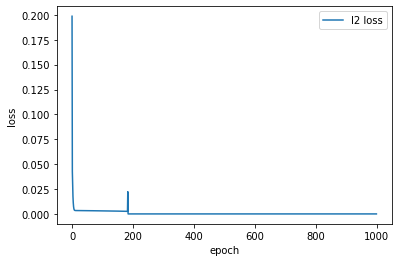

In [8]:
x = np.arange(0, opt.max_epochs)
epoch_loss = epoch_loss.data.numpy()
plt.figure()
l = plt.plot(x, epoch_loss, label = 'l2 loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()



# Test & Visualization

In [26]:
net = FCN32s(pretrained_net = VGG, n_class = 1)
net.load_state_dict(torch.load("/home/zhizuo/Landmark/models/FCN32s_2020_3_28_23.pkl"))
net.eval()
net.cpu()

FCN32s(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

912


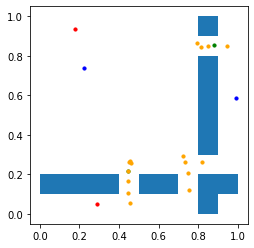

In [102]:
# net = FCN32s(pretrained_net = VGG, n_class = 1)
# net.load_state_dict(torch.load("/home/zhizuo/Landmark/models/FCN32s_2020_3_28_23.pkl"))
# net.eval()
# net.cpu()

idx = np.random.choice(range(int(numtotal*ratioTestTrain), numtotal))
print(idx)
testing_data = data[idx,[0,2,3]]
testing_label = data[idx, 1]
testing_data = torch.FloatTensor(testing_data)
testing_data = testing_data.view(1,testing_data.shape[0], testing_data.shape[1], -1)

predict_label = net(testing_data)
predict_label = predict_label.view(predict_label.shape[2], -1)
predict_label = predict_label.detach().numpy()

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect = 'equal')
for i in range(testing_label.shape[0]):
    for j in range(testing_label.shape[1]):
        if testing_data[0][0][i][j] == 0:
            ax1.add_patch(patches.Rectangle((i/testing_label.shape[0], j/testing_label.shape[1]),
                                           1/testing_label.shape[0], 1/testing_label.shape[1]))
        if testing_label[i][j] == 1:
            #print("fuck")
            #ax1.add_patch(patches.Rectangle((i/testing_label.shape[0], j/testing_label.shape[1]), 
                          #1/testing_label.shape[0], 1/testing_label.shape[1]))
            plt.scatter(i/testing_label.shape[0], j/testing_label.shape[1], color = 'green', s=10)
        if testing_data[0][1][i][j] == 1:
            plt.scatter(i/testing_label.shape[0], j/testing_label.shape[1], color = 'red', s=10)
        if testing_data[0][2][i][j] == 1:
            plt.scatter(i/testing_label.shape[0], j/testing_label.shape[1], color = 'blue', s=10)
        if predict_label[i][j] >= 0.1:
            plt.scatter(i/testing_label.shape[0], j/testing_label.shape[1], color = 'orange', s=10)
            

plt.show() 



# Test of more complicated cases

(160, 160)


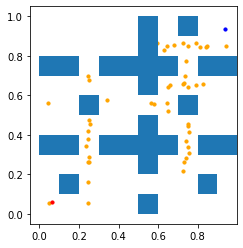

In [105]:
net = FCN32s(pretrained_net = VGG, n_class = 1)
net.load_state_dict(torch.load("/home/zhizuo/Landmark/models/FCN32s_2020_3_28_23.pkl"))

net.eval()
net = net.cpu()
test_x = np.array([1,1,1,0,1,1,1,0,1,1,\
                   1,0,1,0,1,1,1,0,1,1,\
                   1,1,1,1,1,0,1,1,1,1,\
                   1,1,1,0,1,1,1,0,1,1,\
                   1,1,1,0,1,1,1,0,1,1,\
                   0,1,0,0,0,1,0,0,0,0,\
                   1,1,1,0,1,1,1,0,1,1,\
                   1,1,1,1,1,0,1,1,1,0,\
                   1,0,1,0,1,1,1,0,1,1,\
                   1,1,1,0,1,1,1,0,1,1])
test_x = test_x.reshape(10,10)
init_x = np.zeros((10*opt.grid,10*opt.grid))
init_x[10][10] = 1
goal_x = np.zeros((10*opt.grid,10*opt.grid))
goal_x[150][150] = 1
test_x = test_x.repeat(opt.grid, axis = 0)
test_x = test_x.repeat(opt.grid, axis = 1)

test_input = []
test_input.append(test_x)
test_input.append(init_x)
test_input.append(goal_x)
test_input = np.array(test_input)
test_input = test_input.reshape(1, 3, test_input.shape[2], -1)
test_input = torch.FloatTensor(test_input)

predict_label = net(test_input)
predict_label = predict_label.view(predict_label.shape[2], -1)
predict_label = predict_label.detach().numpy()
print(predict_label.shape)


dim = test_input.shape[2]

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect = 'equal')
for i in range(dim):
    for j in range(dim):
        #print("i, j = ", i, j)
        if test_x[i][j] == 0:
            ax1.add_patch(patches.Rectangle((i/dim, j/dim),
                                           1/dim, 1/dim))
        #if testing_label[i][j] == 1:
            #print("fuck")
            #ax1.add_patch(patches.Rectangle((i/testing_label.shape[0], j/testing_label.shape[1]), 
                          #1/testing_label.shape[0], 1/testing_label.shape[1]))
            #plt.scatter(i/testing_label.shape[0], j/dim, color = 'green', s=10)
        if init_x[i][j] == 1:
            plt.scatter(i/dim, j/dim, color = 'red', s=10)
        if goal_x[i][j] == 1:
            plt.scatter(i/dim, j/dim, color = 'blue', s=10)
        if predict_label[i][j] >= 0.2:
            plt.scatter(i/dim, j/dim, color = 'orange', s=10)
            
plt.show()



